In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
import random

import scipy.cluster.hierarchy as sch
from scipy import stats

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

In [2]:
### READ DATA ###

data, person_id = [], []
for txt in listdir('Walk_MODEL'):
    measure = pd.read_csv('Walk_MODEL/'+txt, sep=' ', header=None).values
    data.append(measure)
    person_id.append(txt.split('-')[-1].split('.')[0])

data = np.asarray(data)
data.shape

(20, 170, 3)

Text(0.5, 0, 'Time')

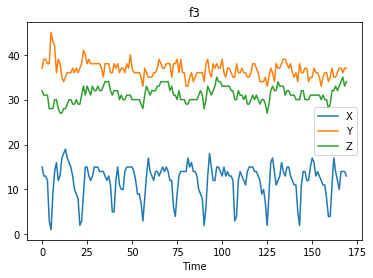

In [3]:
### EXEMPLE OF DATA FOR A SINGLE INDIVIDUAL ###

plt.plot(data[11])
plt.legend(['X','Y','Z'])
plt.title(person_id[11]); plt.xlabel('Time')

In [4]:
### STANDARDIZE DATA ###

for i,s in enumerate(data):
    data[i] = (data[i] - s.mean(axis=0)) / s.std(axis=0)

# DIMENSIONALITY REDUCTION

In [5]:
def get_autoencoder(data):

    input_layer = Input(shape=(data.shape[1], data.shape[2]))
    
    encoder = TimeDistributed(Dense(200, activation='tanh'))(input_layer)
    encoder = TimeDistributed(Dense(50, activation='tanh'))(encoder)
    latent = TimeDistributed(Dense(10, activation='tanh'))(encoder)
    decoder = TimeDistributed(Dense(50, activation='tanh'))(latent)
    decoder = TimeDistributed(Dense(200, activation='tanh'))(decoder)

    out = TimeDistributed(Dense(3))(decoder)

    autoencoder = Model(inputs=input_layer, outputs=out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [6]:
autoencoder = get_autoencoder(data)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 170, 3)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 170, 200)          800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 170, 50)           10050     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 170, 10)           510       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 170, 50)           550       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 170, 200)          10200     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 170, 3)            603   

In [7]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


es = EarlyStopping(monitor='val_loss', mode='auto', restore_best_weights=True, verbose=1, patience=0)

autoencoder = get_autoencoder(data)
autoencoder.fit(data[:10],data[:10], epochs=200, verbose=2, validation_data=(data[:10],data[:10]), callbacks=[es])

Train on 10 samples, validate on 10 samples
Epoch 1/200
10/10 - 1s - loss: 0.4554 - val_loss: 0.3788
Epoch 2/200
10/10 - 0s - loss: 0.3788 - val_loss: 0.3088
Epoch 3/200
10/10 - 0s - loss: 0.3088 - val_loss: 0.2441
Epoch 4/200
10/10 - 0s - loss: 0.2441 - val_loss: 0.1857
Epoch 5/200
10/10 - 0s - loss: 0.1857 - val_loss: 0.1361
Epoch 6/200
10/10 - 0s - loss: 0.1361 - val_loss: 0.0978
Epoch 7/200
10/10 - 0s - loss: 0.0978 - val_loss: 0.0718
Epoch 8/200
10/10 - 0s - loss: 0.0718 - val_loss: 0.0574
Epoch 9/200
10/10 - 0s - loss: 0.0574 - val_loss: 0.0522
Epoch 10/200
Restoring model weights from the end of the best epoch.
10/10 - 0s - loss: 0.0522 - val_loss: 0.0529
Epoch 00010: early stopping


Text(0, 0.5, 'mse')

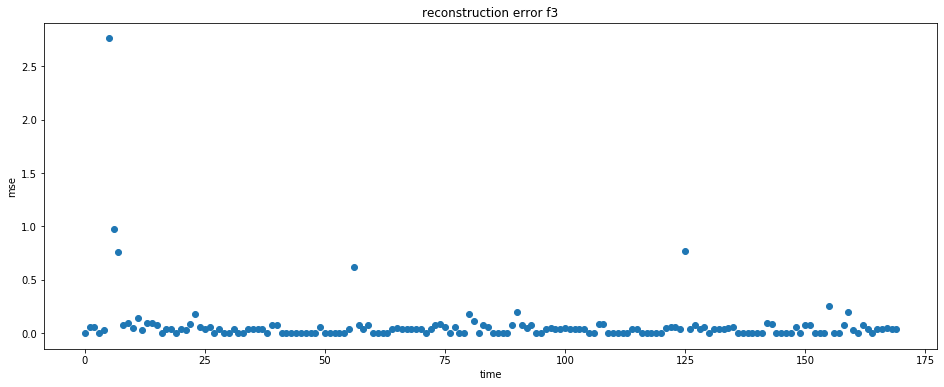

In [8]:
### TRY TO RECONSTRUCT ERRORS ###

predictions = autoencoder.predict([[data[11]]])
mse = np.mean(np.power(data[11] - predictions, 2), axis=2)

plt.figure(figsize=(16,6))
plt.scatter(range(data.shape[1]), mse)
plt.title('reconstruction error '+person_id[11])
plt.xlabel('time'); plt.ylabel('mse')

# Pearson Correlation CLUSTERING

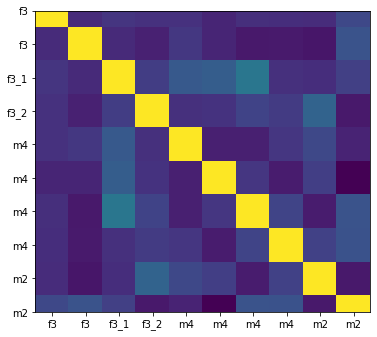

In [9]:
# ### COMPUTE CORRELATION MATRIX ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

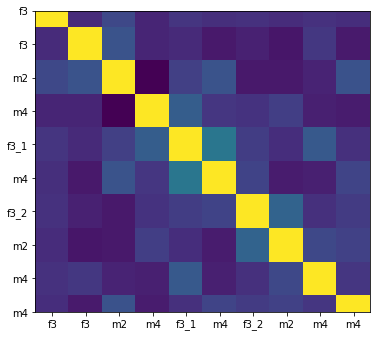

In [10]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(corr)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
corr = np.corrcoef(df)

plt.figure(figsize=(6,6))
plt.imshow(corr)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

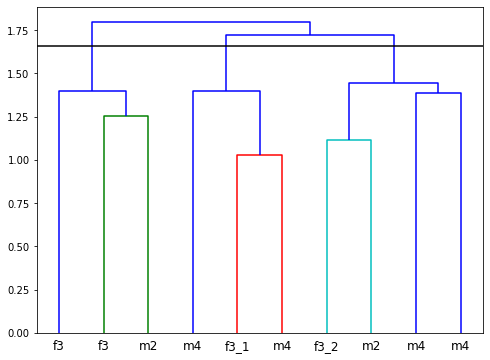

In [11]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')

# Kolmogorov-Smirnov CLUSTERING

In [12]:
def KScoeff(df):
    
    ks_matrix = np.zeros((len(df),len(df)))
    for i in range(len(df)):
        for j in range(i+1,len(df)):
            ks_test = stats.ks_2samp(df[i], df[j])
            ks_matrix[i,j] = ks_test.statistic
            ks_matrix[j,i] = ks_test.statistic
            
    return ks_matrix

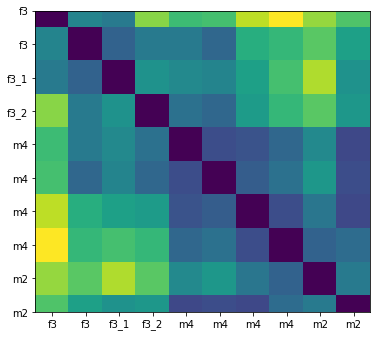

In [13]:
### COMPUTE KOLMOGOROV SMIRNOV MATRIX ###

df = np.mean(np.power(data[10:] - autoencoder.predict(data[10:]), 2), axis=2)
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), person_id[10:])
plt.yticks(range(len(person_id[10:])), person_id[10:])
np.set_printoptions(False)

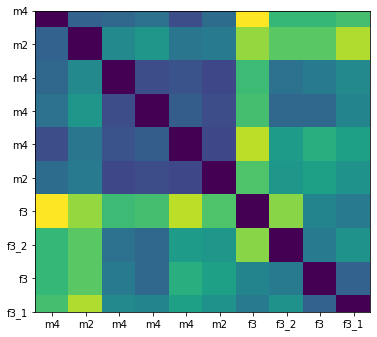

In [14]:
### HIERACHICAL CLUSTERING ###

d = sch.distance.pdist(ks_matrix)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

df = [df[i] for i in dendrogram['leaves']]
labels = [person_id[10:][i] for i in dendrogram['leaves']]
ks_matrix = KScoeff(df)

plt.figure(figsize=(6,6))
plt.imshow(ks_matrix)
plt.xticks(range(len(person_id[10:])), labels)
plt.yticks(range(len(person_id[10:])), labels)
np.set_printoptions(False)

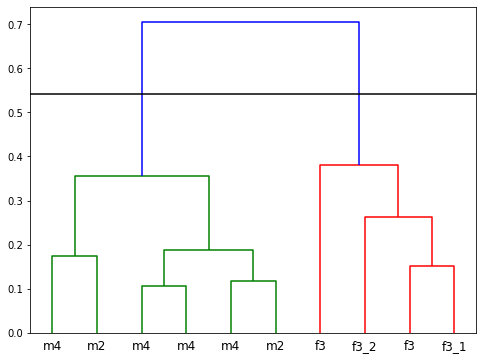

In [15]:
### PLOT DENDROGRAM ###

plt.figure(figsize=(8,6))
dendrogram = sch.dendrogram(L, labels=person_id[10:])
plt.axhline(d.max(), c='black')